In [423]:
import init_notebook

In [424]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.interpolate import Rbf

from task5_util import time_delay_embedding, get_trajectory_distances, get_speed, distance, get_y_value

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [425]:
with open('task_5/MI_timesteps.txt', 'r', encoding='utf-8') as data:
    labels, *data_points = re.split(r'\n+', data.read())
labels = labels.split(' ')
data_points = [data_point for data_point in data_points if data_point != '']

In [426]:
data = {label: [] for label in labels}

for data_point in data_points:
    values = list(map(int, data_point.split(' ')))
    for label, value in zip(labels, values):
        data[label].append(value)

data = pd.DataFrame(data)
data = data[1000:]
display(data)

,timeStep,areaDensityCounting-PID5,areaDensityCounting-PID6,areaDensityCounting-PID7,areaDensityCounting-PID8,areaDensityCounting-PID9,areaDensityCounting-PID10,areaDensityCounting-PID11,areaDensityCounting-PID12,areaDensityCounting-PID13
1000,1001,0,2,97,7,0,0,5,1,43
1001,1002,0,2,96,7,0,0,5,1,45
1002,1003,0,2,95,6,0,0,5,0,46
1003,1004,0,2,94,6,0,0,4,1,46
1004,1005,0,2,92,6,0,0,5,0,46
...,...,...,...,...,...,...,...,...,...,...
14996,14997,0,10,95,4,0,0,2,1,39
14997,14998,0,10,94,3,0,0,3,1,39
14998,14999,0,10,93,3,0,1,2,1,40
14999,15000,0,10,93,3,0,1,3,1,41


In [427]:
# timesteps = []
# sums = []
# for point in data.iterrows():
#     timesteps.append(point[0])
#     sums.append(point[1][1:].sum())

# totals_figure = plt.figure()
# totals_plot = totals_figure.add_subplot(111)

# totals_plot.plot(timesteps, sums)

# totals_plot.set_title('Total count in all areas over time')
# totals_plot.set_ylabel('Total')
# totals_plot.set_xlabel('timestep')

# totals_figure.tight_layout()

# Q: Create a reasonable state space for the given system.

The dataset consists of measurements for multiple areas of the Garching campus. Our state space will be in $\mathbb{R}^9$ in which each data point contains the measure for each area, in the order they are given in the input file, in a coordinate. Although the timestep is included in the dataset this information will not be present in our state space and will be used later, coupled with the corresponding data point, for the analysis of the system. This state space allows us to capture the full dynamics of the flow of people between areas given the available sensors.

# Q: How many dimensions will you need to embed the dataset according to Takens theorem?

According to Takens theorem the number of dimentions of the embedding will be:

$$
2d+1
$$

where $d$ is the dimention of the manifold that contains the dataset. Since the dataset is periodic and has no parametric dependency it will form a one-dimentional closed loop, as mentioned in the exercise sheet. This means that $d=1$ and that the number of dimentions of the embedding is $2\times 1 + 1=3$.

In [428]:
TIME_DELAY = 350

# Remove time steps and columns after first three from data
data_without_timesteps = data.drop(columns='timeStep')
columns_to_drop = data_without_timesteps.columns[3:]
three_columns = data_without_timesteps.drop(columns=columns_to_drop)

# Create the time delay embeddings dataset
i = 0
embeddings_dataset = []
n_rows, _ = three_columns.shape
while n_rows - i > TIME_DELAY:
    raw_embedding = time_delay_embedding(three_columns[i:], delay=TIME_DELAY)
    embeddings_dataset.append(raw_embedding.flatten())
    i+=1

embeddings_dataset = np.array(embeddings_dataset)

In [429]:
# Perform pca on the embeddings
pca = PCA(n_components=embeddings_dataset.shape[1])
pca_embeddings_dataset = pca.fit_transform(embeddings_dataset)

In [430]:
# According to takens theorem we need a minimum of three dimentions to embed the dataset
# so that is the number of components we will select from pca

pca_embeddings_dataset = pca_embeddings_dataset[:,:3]


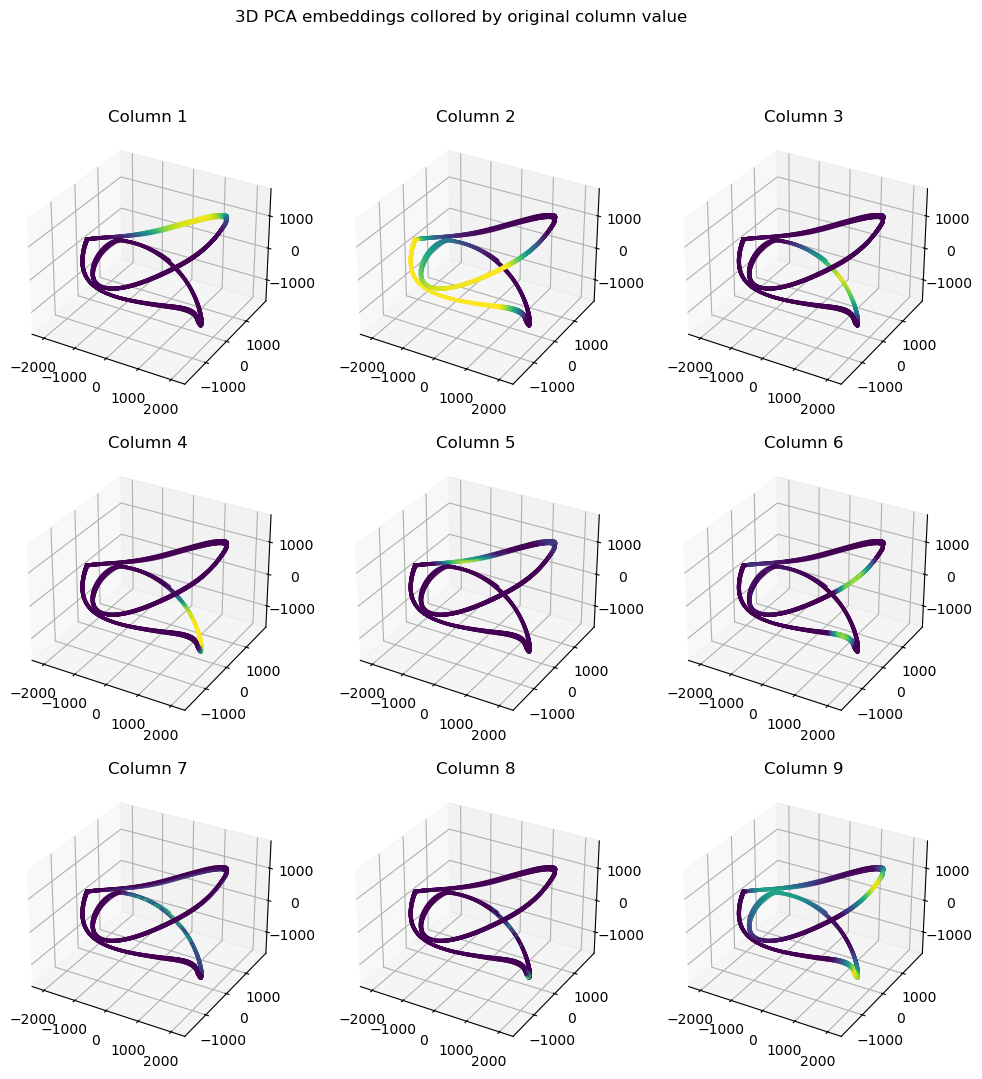

In [431]:
point_2_figure = plt.figure(figsize=(12,12))
point_2_figure.suptitle('3D PCA embeddings collored by original column value')

for column in range(9):
    column_plot = point_2_figure.add_subplot(3, 3, column+1, projection='3d')
    column_plot.scatter(*pca_embeddings_dataset.T, s=1, c=data_without_timesteps.values[:-TIME_DELAY,column])
    column_plot.set_title(f'Column {column+1}')


Text(0, 0.5, 'Average Velocity (% curve length / timestep)')

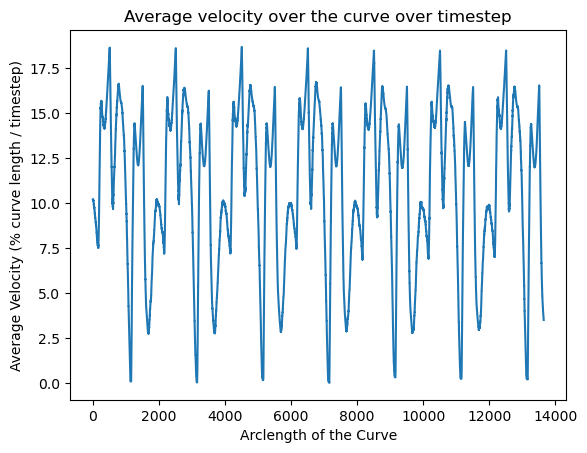

In [432]:
arc_lengths = get_trajectory_distances(pca_embeddings_dataset)
velocities_figure = plt.figure()
velocities_plot = velocities_figure.add_subplot(111)
velocities_plot.plot(range(len(arc_lengths)), arc_lengths)

velocities_plot.set_title('Average velocity over the curve over timestep')
velocities_plot.set_xlabel('Arclength of the Curve')
velocities_plot.set_ylabel('Average Velocity (% curve length / timestep)')

In [433]:
# Calculate curve arclength
# It can be seen that the period is around 2000 timesteps

# This makes sense as 7 days were recorded with 14000 timesteps.
# Assuming these are equally separated in time this means each day
# had 2000 observations (the period).

PERIOD = 2000
total_arclength = 0
for i in range(len(arc_lengths) - len(arc_lengths) % PERIOD):
    total_arclength += arc_lengths[i]

total_arclength = total_arclength / (len(arc_lengths)//PERIOD)

print(f'The total arc length is approximately {total_arclength}')

The total arc length is approximately 21709.329414898493


In [434]:
current_arc_length = 0
speed_map = {}
points_to_arclengths = []
for arc_length in arc_lengths:
    speed_map[current_arc_length] = arc_length
    points_to_arclengths.append(current_arc_length)
    current_arc_length = (current_arc_length + arc_length) % total_arclength

[Text(0.0, 0, '0'),
 Text(3.141592653589793, 0, 'π'),
 Text(6.283185307179586, 0, '2π')]

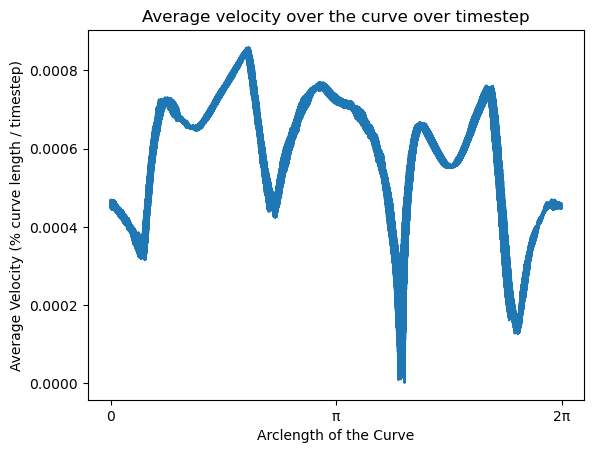

In [435]:
velocities_figure = plt.figure()
velocities_plot = velocities_figure.add_subplot(111)

speed_items = list(speed_map.items())
speed_items.sort(key=lambda x: x[0])

arc_lengths, speeds = np.array(speed_items).T

velocities_plot.plot(arc_lengths/total_arclength * 2*np.pi, speeds/total_arclength)

velocities_plot.set_title('Average velocity over the curve over timestep')
velocities_plot.set_xlabel('Arclength of the Curve')
velocities_plot.set_ylabel('Average Velocity (% curve length / timestep)')

velocities_plot.set_xticks(np.linspace(0, 2*np.pi, 3))
velocities_plot.set_xticklabels(['0', 'π', '2π'])


In [436]:
# Using 2000 timesteps per day

DAYS_TO_PREDICT = 14

current_arc_length = 0
predictions = np.zeros((PERIOD*DAYS_TO_PREDICT,))

for i in range(PERIOD*DAYS_TO_PREDICT-1):
    # Get speed relative to total arc length
    approximate_current_speed = get_speed(speed_map, current_arc_length) / total_arclength
    # update next timestep's position on the curve
    predictions[i+1] = (predictions[i] + approximate_current_speed) % 1


In [437]:
L = 12
epsilon = 1

# X
points_to_arclengths.sort()
print(len(points_to_arclengths), points_to_arclengths)

l_index_array = list(map(int, np.linspace(0, len(points_to_arclengths)-1, L)))

l_array = np.array([points_to_arclengths[i] for i in l_index_array])
print(l_array)

points_to_arclengths = np.array(points_to_arclengths)

# f(X)
labels = data_without_timesteps.values.T[0][:len(points_to_arclengths)]
print(len(labels), labels)

# New X
print(len(predictions), predictions)

# I want f(New X)
...

13650 [0, 9.458744898438454e-11, 4.995140340310172, 5.308234302949131, 6.297244307974324, 6.617297530348878, 8.966386039694044, 9.856702478839116, 10.18792729628341, 14.923176279498177, 15.280508847272142, 16.008695506789643, 16.534190458850595, 18.78847661902448, 19.68540595319337, 20.359037354279884, 24.83060309736114, 25.24645971137554, 25.704281731895804, 26.444269224082987, 28.661199066573463, 29.52914647910827, 30.513596844464267, 34.76594370877289, 35.22637257424774, 35.425577228981105, 36.347798161315076, 38.52635628939844, 39.367929732816904, 40.68364791198655, 44.70714854690899, 45.14271062670818, 45.20024929792598, 46.23863730918643, 48.34721584234222, 49.23284449738819, 50.85849891581433, 54.67643065111878, 54.84365789840918, 55.1878683260824, 56.1001367046375, 58.19524154299594, 59.08165120917096, 61.02810754066165, 64.51777971844365, 64.6628322428271, 65.14623409800907, 65.92779674034753, 68.07040654615503, 68.89626053415206, 71.21320280483353, 74.1350273441088, 74.595739

Ellipsis

In [438]:
N, L = points_to_arclengths.shape[0], l_array.shape[0]
phi = np.zeros((N, L))
for i in range(N):
    for j in range(L):
        phi[i, j] = np.exp(-((points_to_arclengths[i] - l_array[j]) / epsilon) ** 2)

c, residuals, rank, s = np.linalg.lstsq(phi, labels, rcond=None)

In [442]:
#get_y_value(x_value, c, l_vector, epsilon)

mi_building_predictions = list(map(lambda x: get_y_value(x, c, l_array, epsilon), predictions))


In [444]:
mi_building_predictions

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

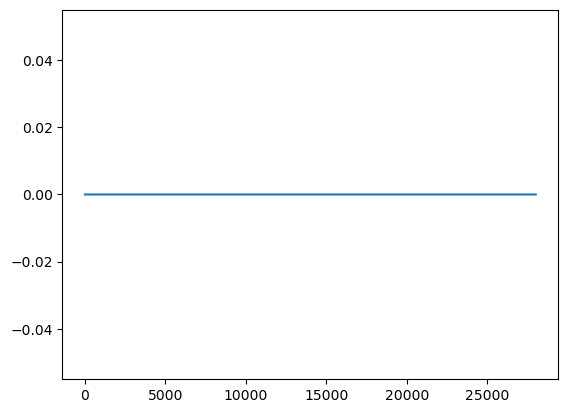

In [443]:
pred_fig = plt.figure()
mi_plot = pred_fig.add_subplot(111)

mi_plot.plot(np.linspace(1, 28000, 28000), mi_building_predictions)